In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
!pip install torch torchvision opencv-python scikit-learn matplotlib tqdm


In [3]:
import os
import cv2
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from sklearn.metrics import classification_report
from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import defaultdict

torch.manual_seed(42)
np.random.seed(42)


In [4]:
from torchvision import transforms
from collections import Counter

class MicroExpressionDataset(Dataset):
    def __init__(self, root_dir, seq_len=32, img_size=(128, 128), min_samples=500, augment=True):
        self.data = []
        self.labels = []
        self.label_map = {}
        self.seq_len = seq_len
        self.img_size = img_size
        self.augment = augment
        label_id = 0

        self.augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.ColorJitter(brightness=0.2, contrast=0.2),
        ])

        for label in sorted(os.listdir(root_dir)):
            path = os.path.join(root_dir, label)
            files = sorted([f for f in os.listdir(path) if f.endswith('.jpg')])
            if len(files) < min_samples:
                print(f"Skipping '{label}' (only {len(files)} frames)")
                continue

            self.label_map[label] = label_id
            sequences = []

            # generate sequences
            for i in range(0, len(files) - seq_len + 1, seq_len):
                seq = []
                for j in range(seq_len):
                    img = cv2.imread(os.path.join(path, files[i + j]), cv2.IMREAD_GRAYSCALE)
                    img = cv2.resize(img, self.img_size) / 255.0
                    seq.append(img)
                sequences.append(seq)
                self.data.append(np.expand_dims(np.array(seq), axis=1))
                self.labels.append(label_id)

            # augment minority class
            if self.augment and len(sequences) < 5:  # tweak this threshold
                for seq in sequences:
                    aug_seq = []
                    for frame in seq:
                        img_pil = transforms.ToPILImage()(torch.tensor(frame).unsqueeze(0))
                        aug_img = self.augmentation(img_pil)
                        aug_img = transforms.ToTensor()(aug_img).squeeze(0).numpy()
                        aug_seq.append(aug_img)
                    self.data.append(np.expand_dims(np.array(aug_seq), axis=1))
                    self.labels.append(label_id)

            label_id += 1

        self.data = np.array(self.data, dtype=np.float32)
        self.labels = np.array(self.labels, dtype=np.int64)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


In [5]:
import matplotlib.pyplot as plt
from collections import Counter

def plot_class_distribution(labels, label_map, title):
    counter = Counter(labels)
    names = list(label_map.keys())
    counts = [counter[label_map[name]] for name in names]

    plt.figure(figsize=(8, 4))
    plt.bar(names, counts, color='skyblue')
    plt.title(title)
    plt.ylabel("Number of Sequences")
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()



In [6]:
class CNN_LSTM(nn.Module):
    def __init__(self, num_classes):
        super(CNN_LSTM, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Flatten()
        )
        self.lstm = nn.LSTM(input_size=64 * 32 * 32, hidden_size=128, num_layers=2, batch_first=True)
        self.classifier = nn.Sequential(
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        b, t, c, h, w = x.size()
        x = x.view(b * t, c, h, w)
        x = self.cnn(x)
        x = x.view(b, t, -1)
        _, (h_n, _) = self.lstm(x)
        return self.classifier(h_n[-1])


In [7]:
def train_model(model, dataloader, optimizer, loss_fn, device):
    model.train()
    running_loss = 0
    for x, y in tqdm(dataloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        outputs = model(x)
        loss = loss_fn(outputs, y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def evaluate_model(model, dataloader, device, label_map):
    model.eval()
    y_true, y_pred = [], []
    correct_per_class = defaultdict(int)
    total_per_class = defaultdict(int)

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            _, preds = torch.max(outputs, 1)
            y_true.extend(y.tolist())
            y_pred.extend(preds.cpu().tolist())

            for t, p in zip(y.tolist(), preds.cpu().tolist()):
                total_per_class[t] += 1
                if t == p:
                    correct_per_class[t] += 1

    print(classification_report(y_true, y_pred, target_names=list(label_map.keys())))

    print("\nClass-wise Accuracy:")
    # Correct class-wise accuracy output
    inv_map = {v: k for k, v in label_map.items()}
    for cls_idx in sorted(inv_map.keys()):
        correct = correct_per_class[cls_idx]
        total = total_per_class[cls_idx]
        acc = correct / total if total > 0 else 0
        print(f"{inv_map[cls_idx]:<10}: {acc:.2f}")


Skipping 'fear' (only 127 frames)
Skipping 'sadness' (only 274 frames)


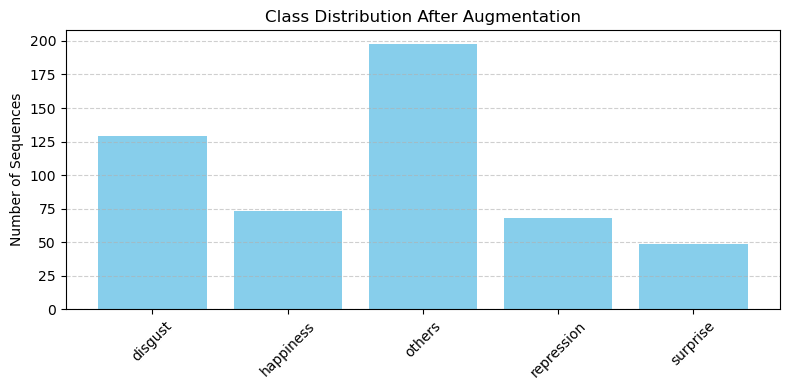

In [8]:
from sklearn.utils.class_weight import compute_class_weight
from torch.utils.data import WeightedRandomSampler

# Replace this with the correct path to your dataset
data_path = 'C:/Users/sachi/Downloads/CASME2_Preprocessed_ v2'

dataset = MicroExpressionDataset(data_path)


# Visualize before training
plot_class_distribution(dataset.labels, dataset.label_map, "Class Distribution After Augmentation")

In [9]:
print(dataset.labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [20]:

train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = random_split(dataset, [train_size, val_size])

def get_balanced_loader(subset, batch_size=8):
    full_dataset = subset.dataset
    indices = subset.indices
    
    subset_labels = [full_dataset.labels[i] for i in indices]
    class_count = Counter(subset_labels)
    class_weights = {cls: 1.0 / count for cls, count in class_count.items()}
    sample_weights = [class_weights[label] for label in subset_labels]
    
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
    loader = DataLoader(subset, batch_size=batch_size, sampler=sampler)
    return loader

train_loader = get_balanced_loader(train_ds, batch_size=8)
val_loader = DataLoader(val_ds, batch_size=8)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_LSTM(num_classes=len(dataset.label_map)).to(device)

# Compute weights
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(dataset.labels),
                                     y=dataset.labels)
weights = torch.tensor(class_weights, dtype=torch.float).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss(weight=weights)

for epoch in range(1, 15):
    loss = train_model(model, train_loader, optimizer, loss_fn, device)
    print(f"Epoch {epoch}, Loss: {loss:.4f}")


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:07<00:00,  7.28it/s]


Epoch 1, Loss: 1.5810


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:06<00:00,  7.69it/s]


Epoch 2, Loss: 1.5464


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:06<00:00,  7.65it/s]


Epoch 3, Loss: 1.4693


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:06<00:00,  7.64it/s]


Epoch 4, Loss: 1.2701


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:06<00:00,  7.65it/s]


Epoch 5, Loss: 1.1384


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:06<00:00,  7.57it/s]


Epoch 6, Loss: 0.9617


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:06<00:00,  7.66it/s]


Epoch 7, Loss: 0.8466


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:06<00:00,  7.51it/s]


Epoch 8, Loss: 0.6899


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:06<00:00,  7.61it/s]


Epoch 9, Loss: 0.6228


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:06<00:00,  7.59it/s]


Epoch 10, Loss: 0.5023


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:06<00:00,  7.58it/s]


Epoch 11, Loss: 0.4475


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:06<00:00,  7.46it/s]


Epoch 12, Loss: 0.3907


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:06<00:00,  7.55it/s]


Epoch 13, Loss: 0.2637


100%|██████████████████████████████████████████████████████████████████████████████████| 52/52 [00:06<00:00,  7.58it/s]

Epoch 14, Loss: 0.2499


In [21]:
print("Evaluation on Validation Set:")
evaluate_model(model, val_loader, device, dataset.label_map)


Evaluation on Validation Set:
              precision    recall  f1-score   support

     disgust       0.96      0.93      0.95        28
   happiness       1.00      0.95      0.97        19
      others       0.97      1.00      0.99        33
  repression       1.00      1.00      1.00        13
    surprise       0.92      1.00      0.96        11

    accuracy                           0.97       104
   macro avg       0.97      0.98      0.97       104
weighted avg       0.97      0.97      0.97       104


Class-wise Accuracy:
disgust   : 0.93
happiness : 0.95
others    : 1.00
repression: 1.00
surprise  : 1.00
